<a href="https://colab.research.google.com/github/Andre6o6/stylegan-editing/blob/master/StyleGAN_edit_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x

In [ ]:
!git clone https://github.com/genforce/interfacegan.git

In [ ]:
!gdown https://drive.google.com/uc?id=1r3Qygz6DaXtQwkUbd35ucA2U4hayj32m
!mv "karras2019stylegan-ffhq-1024x1024.pkl" interfacegan/models/pretrain/

In [ ]:
!git clone https://github.com/Andre6o6/stylegan-editing.git

In [ ]:
!pip install ffmpeg-python
!pip install scikit-video

In [5]:
!mkdir latents/
!mkdir raw_images/ aligned_images/

## Download FEI database 
https://fei.edu.br/~cet/facedatabase.html

In [ ]:
!wget https://fei.edu.br/~cet/originalimages_part1.zip
#!wget https://fei.edu.br/~cet/originalimages_part2.zip
#!wget https://fei.edu.br/~cet/originalimages_part3.zip
#!wget https://fei.edu.br/~cet/originalimages_part4.zip

In [ ]:
!mkdir data
!mkdir data/fei
!unzip originalimages_part1.zip -d data/fei/

In [ ]:
# Choose images, corresponding to desired semantic, in our case - head pose
!cp data/fei/{*-13,*-03}.jpg raw_images/

## Align images and project them into latent space

In [ ]:
!python stylegan-editing/align/align_images.py raw_images/ aligned_images/ --output_size=1024

In [ ]:
!python encode_images.py

## Calculate direction, corresponding to semantic change

In [18]:
import glob
import numpy as np
import skvideo.io

from interfacegan.models.stylegan_generator import StyleGANGenerator
from moviepy.editor import VideoFileClip
from PIL import Image

In [8]:
diff = np.zeros((1,512))
n = 0
for file1, file2 in zip(sorted(glob.glob("latents/*-13_01.png.npy")), 
                        sorted(glob.glob("latents/*-03_01.png.npy"))):
    x0 = np.load(file1)
    x1 = np.load(file2)

    diff += (x1-x0).mean(1)
    n+=1
diff /= n
np.save("headpose_boundary.npy", diff)

## Compare to GT

In [16]:
def generate_image(x):
    g = converted_model.synthesize(x, "WP")
    return converted_model.postprocess(g["image"])[0]

generated:


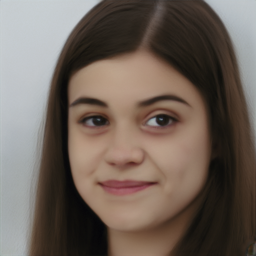

ground truth:


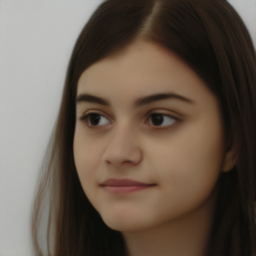

In [24]:
x0 = np.load("latents/11-13_01.png.npy")
x1 = np.load("latents/11-03_01.png.npy")

print("generated:")
display(Image.fromarray(generate_image(x0+diff)).resize((256,256)))
print("ground truth:")
display(Image.fromarray(generate_image(x1)).resize((256,256)))

## Generate animation

In [ ]:
converted_model = StyleGANGenerator("stylegan_ffhq")

In [14]:
anim = []
n_frames = 120
base = np.load("latents/11-13_01.png.npy")

for w in np.linspace(base, base+2*diff, n_frames):
    g = generate_image(w)
    anim.append(g)
skvideo.io.vwrite("headpose.mp4", anim)

In [15]:
clip = VideoFileClip('headpose.mp4')
clip.ipython_display(height=512, autoplay=1, loop=1)

 99%|█████████▉| 120/121 [00:02<00:00, 50.22it/s]
